Author: Nassim Boutouchent

# InSPIRe Vaginal Resistome Jupyter Notebook (2): Diversity Analysis 

**Author: Nassim Boutouchent**

In this second notebook, we compute and visualize diversity metrics at multiple levels: **species**, **ARGs**, and **MGEs**.

This notebook is organized into 4 sections:
1. Descriptive analysis of ARGs and MGE in the VM of pregnant women (inspire cohorte)
2. α- and β-diversity calculation and visualization  
3. Diferential abundance plot (using maaslin2 oouput)
4. Cross-validation ((i) with different ARGs database and (ii) with an independant cohort: ENA Acc#: PRJEB34536)  

**Note:** Statistical analyses are reported in a separate R Markdown notebook (inspire_analysis3_StatisticalTesting)



## Load libraries  

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import skbio

## Load & process data 

In [2]:
#import ARGs, MGE and species frequency tables 
RF_ARGs_abun = pd.read_csv("../data/Norm/ARG_count_RF_RPKM_Gene.csv", index_col='SampleID')
MGE_abun = pd.read_csv("../data/Norm/MGE_count_RF_RPKM_Gene.csv", index_col='SampleID')
Taxonomy = pd.read_csv("../data/Norm/inspire_taxonomy_count_sp.csv", index_col=0)
Taxa_rabun = pd.read_csv("../data/Norm/inspire_taxonomy_rabun_sp.csv", index_col=0)

# Metadata
metadata = pd.read_csv("../data/inspire_VR_metadata.csv", index_col=0)

In [3]:
# import dictionaries (for mapping genes to their initial header information e.g. antibiotic class)

# ARGs dict
with open("../data/supp_materials/RF_gene_info_dict.json") as f:
    RF_dict = json.load(f)
# MGE dict 
with open("../data/supp_materials/MGE_gene_info_dict.json") as f:
    MGE_dict = json.load(f)

# import and root trees

#mooncrater
PhenoARGTree = "../data/supp_materials/PhenoARGTree.newick"
tree_ARG = skbio.TreeNode.read(PhenoARGTree)
tree_rooted_ARG = tree_ARG.root_at(tree_ARG)

#moonbase
moonbase = "../data/supp_materials/moonbase_v1.newick"
tree_taxa = skbio.TreeNode.read(moonbase)
tree_rooted_taxa = tree_taxa.root_at(tree_taxa)

In [4]:
# calculate relative abundance of ARGs and MGEs tables ; keep all samples.  
def calc_rabun(df_abun):
    df_rabun = df_abun.copy()
    sums = df_rabun.sum(axis=1)
    df_rabun = df_rabun.div(sums.replace(0, np.nan), axis=0)
    return df_rabun.fillna(0)

# rAbun 
RF_ARGs_rabun = calc_rabun(RF_ARGs_abun)
MGE_rabun = calc_rabun(MGE_abun)
print(RF_ARGs_rabun.shape)
print(MGE_rabun.shape)


(1957, 231)
(1957, 157)


In [5]:
# MGE family 
gene_to_family = {entry['MGE']: entry['family'] for entry in MGE_dict}
temp = MGE_rabun.rename(columns=gene_to_family)
MGE_rabun_family = temp.groupby(by=temp.columns, axis=1).sum()
#group Tn916 family ORFs
MGE_rabun_family_clean = MGE_rabun_family.copy()
cols = [Tn for Tn in MGE_rabun_family.columns if Tn.startswith("Tn916-")]
MGE_rabun_family_clean["Tn916"] = MGE_rabun_family_clean[cols].sum(axis=1)
MGE_rabun_family_clean.drop(columns=cols, inplace=True)

## (1) Descriptive figures

In [6]:
#Plot1: Bubble plot to visualize the most abundant and most prevalent features at the same time
def plot_bubble(df, feature_info, top=20, class_colors=None, title=None, gene_entry="Gene", class_entry="Antibiotic_Class", plot=None):
    top_genes = df.mean().sort_values(ascending=False).head(top).index.tolist()
    top_rabun = df[top_genes]
    prev = (top_rabun > 0).mean(axis=0) * 100
    gene_stats = pd.DataFrame({"Gene": top_rabun.columns,
                               "Mean_Abundance": top_rabun.mean().values,
                               "Prevalence": prev.values})
    def prev_to_size(p):
        if p <= 5:
            return 10
        elif p <= 20:
            return 200
        else:
            return 400
    gene_stats["Size"] = gene_stats["Prevalence"].apply(prev_to_size)
    gene_to_class = {entry[gene_entry]: entry[class_entry] for entry in feature_info}
    gene_stats["Class"] = gene_stats["Gene"].map(gene_to_class)
    gene_stats["Gene"] = pd.Categorical(gene_stats["Gene"], categories=gene_stats["Gene"], ordered=True)

    plot = plot or plt.gca()
    sns.scatterplot(data=gene_stats, y="Gene",x="Mean_Abundance", hue="Class", size="Size",sizes=(20, 400), palette=class_colors, ax=plot)
    plot.set_xscale("log")
    plot.set_xlim(1e-3, 1)
    plot.set_xlabel("(%) Mean abundance")
    plot.set_title(title)
    plot.grid(True, color="gray", alpha=0.2)

    return plot

# Plot2: Stacked bar chart for relative abundance visualization
def plot_barchart(df, metadata=None, by = None, top=10, color_map=None, title=None, plot=None):
    if by is None:
        grouped = df.mean(axis=0).to_frame().T
        grouped.index = ["samples"]
    else:
        groups = metadata.loc[df.index, by]
        grouped = df.groupby(groups).mean()
    top_families = grouped.sum().sort_values(ascending=False).head(top).index
    grouped["other"] = grouped.drop(columns=top_families).sum(axis=1)
    grouped = grouped[list(top_families) + ["other"]]
    grouped = grouped.div(grouped.sum(axis=1), axis=0)
    
    plot = plot or plt.gca()
    grouped.plot(kind="bar", stacked=True, color=color_map, edgecolor= "white", ax=plot)
    plot.set_ylabel("Relative abundance")
    plot.set_ylim(0, 1)
    plot.set_title(title)
    plot.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    return plot

# Plot3: Stacked area chart with optional spline smoothing (to enhance visualization and highlight global trends)
def plot_smoothchart(df, metadata, by="CST", top=10, color_map=None, title=None, inter_point=200, k=3, plot=None):
    from scipy.interpolate import make_interp_spline
    groups = metadata.loc[df.index, by]
    grouped = df.groupby(groups).mean()
    top_feats = grouped.sum().sort_values(ascending=False).head(top).index
    grouped["other"] = grouped.drop(columns=top_feats).sum(axis=1)
    grouped = grouped[list(top_feats) + ["other"]]
    grouped = grouped.div(grouped.sum(axis=1), axis=0)

    plot = plot or plt.gca()
    x = np.arange(len(grouped))
    xi = np.linspace(x.min(), x.max(), inter_point)
    baseline = np.zeros(len(xi))
    for col in grouped.columns:
        yi = make_interp_spline(x, grouped[col], k=k)(xi)
        plot.fill_between(xi, baseline, baseline + yi, color=(color_map or {}).get(col),label=col)
        baseline += yi
        
    plot.set_ylim(0, 1)
    plot.set_ylabel("Relative abundance")
    plot.set_title(title)
    plot.set_xticks(x)
    plot.set_xticklabels(grouped.index, rotation=0)
    plot.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    return plot

# Plot 4: richness per antibiotic class
def plot_richness(df, feature_info, gene_entry="Gene", class_entry="Antibiotic_Class", plot=None):
    gene_to_class = {entry[gene_entry]: entry[class_entry] for entry in feature_info}
    res = []
    for gene_class in sorted(set(gene_to_class.values())):
        genes = [g for g, c in gene_to_class.items() if c == gene_class and g in df]
        res.append((gene_class, (df[genes] > 0).any().sum()))
    out = pd.DataFrame(res, columns=["Class", "Richness"]).sort_values("Richness")
    
    plot = plt.gca()

    plot.scatter(out["Richness"], out["Class"], s=60, marker="s",color = '#9999CC', edgecolor="black", linewidth=0.5)
    plot.set_xlabel("ARG richness")
    plot.set_ylabel("Antibiotic class")
    plot.grid(True, color="gray", alpha=0.2)
    return plot

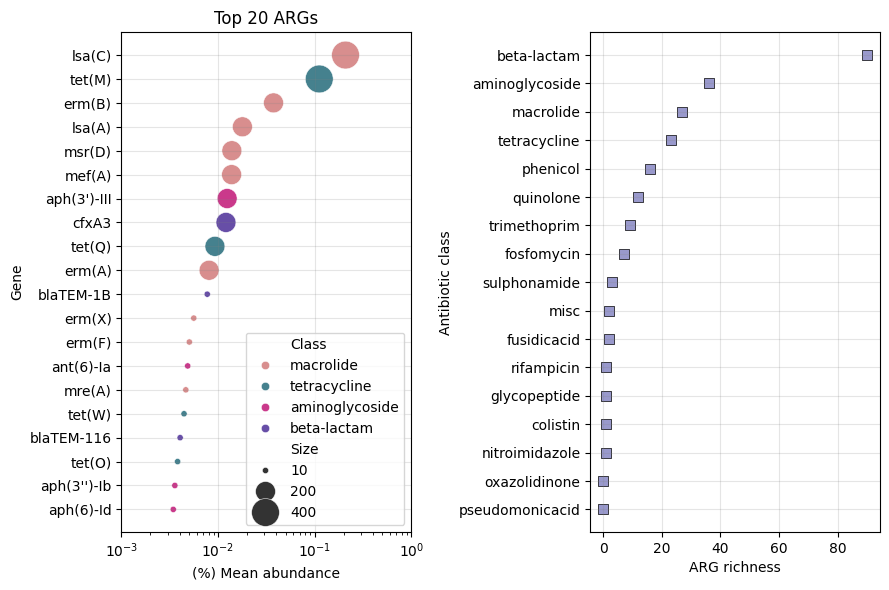

In [7]:
# plot the most frequent and abundant ARGs 
class_palette_RF = {"macrolide": "#D88E8E","tetracycline": "#45818e","aminoglycoside": "#CA398B","beta-lactam": "#674ea7","fosfomycin": "#A79602",
                    "colistin": "#349408","fusidicacid": "#DFBE54","glycopeptide": "#003699","rifampicin": "#6fa8dc","quinolone": "#3C78D8",
                    "phenicol": "#8F6B32","sulphonamide": "#6AA84F","trimethoprim": "#93C47D","nitroimidazole": "#E69138","misc": "#999999", "other":"#E0E0E0"}
fig, axes = plt.subplots(1, 2, figsize=(9, 6))
plot_bubble(RF_ARGs_rabun, RF_dict, top=20, gene_entry="Gene",class_entry="Antibiotic_Class", class_colors=class_palette_RF,
    title="Top 20 ARGs", plot=axes[0])
plot_richness(RF_ARGs_abun, RF_dict, gene_entry='Gene', class_entry='Antibiotic_Class', plot= axes[1])
plt.tight_layout()
plt.show()


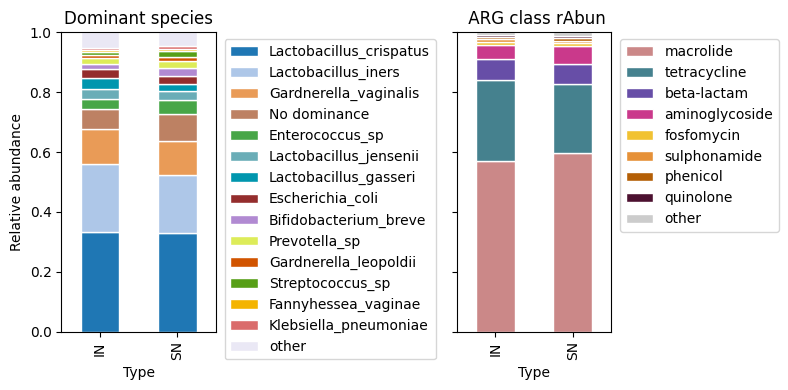

In [8]:
# plot dominant species distribution among samples type (IN : inclusion ; DR (SN) : Delivery room (salle de naissance))
colors_dominantsp = {'Lactobacillus_crispatus': '#1f77b4','Lactobacillus_iners': '#aec7e8','Lactobacillus_gasseri': '#0096AE',
                  'Lactobacillus_jensenii': '#6AADB7','Gardnerella_vaginalis': '#E99B57','Fannyhessea_vaginae': '#f4b400',
                  'Prevotella_sp': '#DDEC59','Enterococcus_sp': '#47A647','Streptococcus_sp': '#579F17','Bifidobacterium_breve': '#B18AD2',
                  'Gardnerella_leopoldii':"#D15400" ,'Escherichia_coli': '#942D2D','Klebsiella_pneumoniae': '#DA6C6C','other': '#EAE8F5','No dominance': '#BD8163'}
colors_ARGClass = {'aminoglycoside': '#CA398B','beta-lactam': '#674ea7','fosfomycin': '#f1c232','fusidicacid': '#c5b0d5',
                   'macrolide': '#CB8888','misc': '#274e13','phenicol': '#b45f06','quinolone': '#4c1130','sulphonamide': '#e69138',
                   'tetracycline': '#45818e','trimethoprim': '#fff2cc','other': '#cccccc'}

# group some species to genus level to enahnce vizualisation 
Taxa_rabun_grouped = Taxa_rabun.copy()
new_cols = []
for c in Taxa_rabun_grouped.columns:
    if c.startswith("Streptococcus_"):
        new_cols.append("Streptococcus_sp")
    elif c.startswith("Enterococcus_"):
        new_cols.append("Enterococcus_sp")
    elif c.startswith("Prevotella_"):
        new_cols.append("Prevotella_sp")
    else:
        new_cols.append(c)
Taxa_rabun_grouped.columns = new_cols
Taxa_rabun_grouped = Taxa_rabun_grouped.groupby(level=0, axis=1).sum()
dominant_sp = Taxa_rabun_grouped.idxmax(axis=1)
dominant_rabun = Taxa_rabun_grouped.max(axis=1)
assigned = []
for sp, ab in zip(dominant_sp, dominant_rabun):
    if ab < 0.3:
        assigned.append("No dominance")
    else:
        assigned.append(sp)
dominant_df = pd.get_dummies(pd.Series(assigned, index=Taxa_rabun_grouped.index))
dominant_df

# Map ARGs to their respective classes for plotting
gene_to_class = {entry["Gene"]: entry["Antibiotic_Class"] for entry in RF_dict}
RF_ARGs_rabun_class = RF_ARGs_rabun.copy()
RF_ARGs_rabun_class.columns = RF_ARGs_rabun_class.columns.map(gene_to_class)
RF_ARGs_rabun_class = RF_ARGs_rabun_class.groupby(level=0,axis=1).sum()


# Plot distribution of samples with a dominant species and ARG relative abundances across the two timepoints (IN and DR).
fig, axes = plt.subplots(1,2, figsize=(8,4), sharey=True)
plot_barchart(dominant_df,metadata,by="Type", top=14, color_map=colors_dominantsp, title="Dominant species", plot=axes[0])
plot_barchart(RF_ARGs_rabun_class, metadata, by= "Type", top=8, color_map=colors_ARGClass, title= " ARG class rAbun", plot=axes[1])
plt.tight_layout()
plt.show()

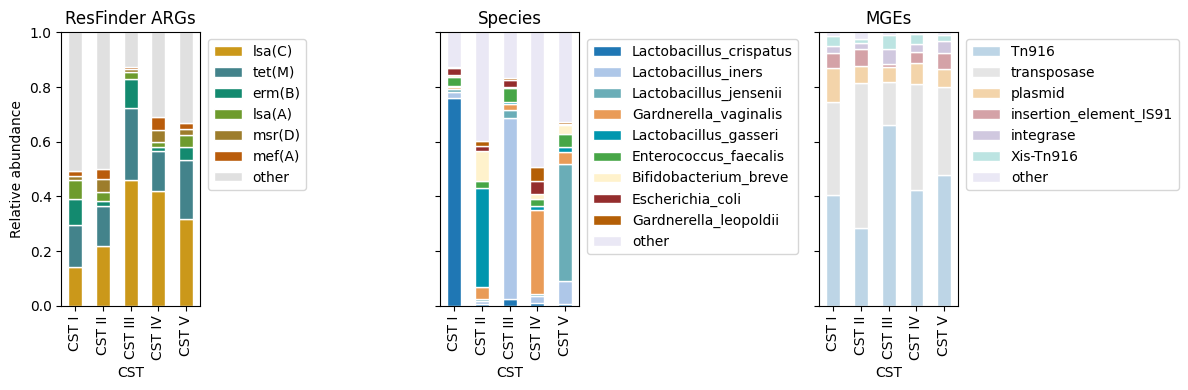

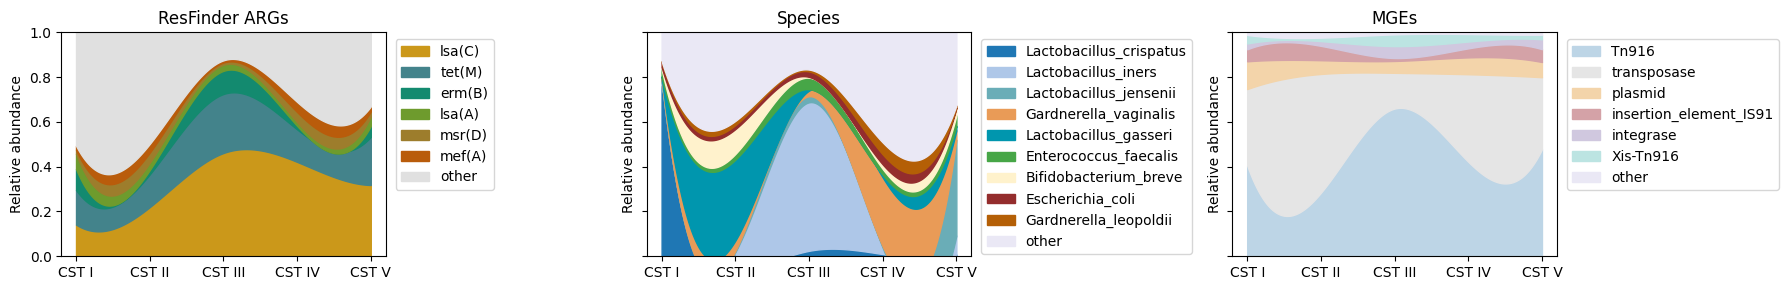

In [9]:
colors_ARGs = {'lsa(C)': '#CB981A', 'tet(M)': '#43838B', 'erm(B)': '#138A6F',
               'lsa(A)': '#6E9B2D', 'msr(D)': '#9D7D2C', 'mef(A)': '#B95C0B','other': '#E0E0E0'}
colors_taxa = {'Lactobacillus_gasseri': '#0096AE','Lactobacillus_crispatus': '#1f77b4',
               'Lactobacillus_jensenii': '#6AADB7','Lactobacillus_iners': '#aec7e8',
               'Gardnerella_vaginalis': '#E99B57','Gardnerella_leopoldii': '#b45f06',
               'Enterococcus_faecalis': '#47A647','Escherichia_coli': '#942D2D',
               'Bifidobacterium_breve': '#fff2cc','other': '#EAE8F5'}
colors_MGE = {'transposase': '#E5E5E5','Tn916': '#BDD5E6','plasmid': '#F3D4AA',
              'insertion_element_IS91': '#D4A2A7','integrase': '#D0C8DF','Xis-Tn916': '#BCE4E2',        
              'istB': '#66B671','istA': '#8BB666','istA11': '#AEB666','other': '#EAE8F5'}

# plot bar chart for species, ARGs and MGEs 
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
plot_barchart(RF_ARGs_rabun, metadata, by="CST", top=6, color_map=colors_ARGs,  title="ResFinder ARGs", plot=axes[0])
plot_barchart(Taxa_rabun,    metadata, by="CST", top=9, color_map=colors_taxa,  title="Species",        plot=axes[1])
plot_barchart(MGE_rabun_family_clean, metadata, by="CST", top=6, color_map=colors_MGE, title="MGEs",    plot=axes[2])
plt.tight_layout()
plt.show()

#Plot area chart for species, ARGs and MGEs 
fig, axes = plt.subplots(1, 3, figsize=(18, 3), sharey=True)
plot_smoothchart(RF_ARGs_rabun, metadata, by="CST", top=6, color_map=colors_ARGs,  title="ResFinder ARGs", plot=axes[0])
plot_smoothchart(Taxa_rabun,    metadata, by="CST", top=9, color_map=colors_taxa,  title="Species",        plot=axes[1])
plot_smoothchart(MGE_rabun_family_clean, metadata, by="CST", top=6, color_map=colors_MGE, title="MGEs",    plot=axes[2])
plt.tight_layout()
plt.show()

## (2) Diversity calculation and figures 

### (2.1) a-diversity metrics

In [10]:
def compute_alpha(df, metric, tree=None):
    series = {}
    if metric=="faith_pd": 
        from skbio.diversity.alpha import faith_pd
        taxa_id = df.columns.tolist()
        for idx in df.index: 
            abun = df.loc[idx, taxa_id].astype(float).to_numpy()
            # for samples without ARGs and MGe detected (which is an impoortant biological information), keep diversity metric at 0
            if abun.sum() == 0:
                series[idx] = 0
            else:
                series[idx] = faith_pd(abun, taxa_id, tree, validate=True)
        return pd.Series(series)
    else: 
        for idx in df.index:
            abun = df.loc[idx].dropna()
            if abun.sum() == 0:
                series[idx] = 0
            else: 
                series[idx] = getattr(skbio.diversity.alpha, metric)(abun) 
        return pd.Series(series)

def plot_box(metric, metadata, by=None, colors=None, title=None, plot=None, order=None):
    groups = metadata.loc[metric.index, by]
    group_level = order
    vector = [metric[groups==g] for g in group_level]

    plot = plot or plt.gca()
    box = plot.boxplot(vector, notch=True, patch_artist=True, showfliers=False, widths=0.5)

    for patch, g in zip(box["boxes"],group_level):
        patch.set_facecolor(colors[g])
        patch.set_edgecolor('black')
    for i, values in enumerate(vector):
        x = np.random.normal(loc=i + 1, scale=0.04, size=len(values))
        plot.scatter(x,values, alpha=0.6,s=4, color="black", edgecolor=colors[group_level[i]],zorder=3)
    plot.set_title(title)
    plot.set_xticklabels(group_level)
    plot.grid(True, axis='y', linestyle='--', alpha=0.5)
    return plot

In [11]:
#Compute Shannon  
shannon_taxa = compute_alpha(Taxonomy, metric="shannon")
shannon_arg = compute_alpha(RF_ARGs_abun, metric="shannon")
shannon_mge = compute_alpha(MGE_abun, metric= "shannon")

#Compute tree based metrics using the faith_pd function
# Convert gene to Accession numbers and format to fit the PhenoARG tree ARG Acc.No 
Gene_to_Acc = {entry["Gene"] : entry["Accession"] for entry in RF_dict}
RF_ARGs_abun_Acc = RF_ARGs_abun.copy()
RF_ARGs_abun_Acc.columns = RF_ARGs_abun_Acc.columns.map(Gene_to_Acc)
RF_ARGs_abun_Acc = RF_ARGs_abun_Acc.groupby(level=0, axis=1).sum()
RF_ARGs_abun_Acc.columns = RF_ARGs_abun_Acc.columns.str.replace(r"^NC_", "NC ", regex=True).str.replace(r"^NG_", "NG ", regex=True)
# remove taxa not in the moonbase tree (maily fungi as it a 16S rRNA gene based tree) 
taxa_not_in_tree = ["Saccharomyces_cerevisiae","Candida_dubliniensis","Megasphaera_Veillonellaceae bacterium DNF00626","Candida_maltosa","Candida_orthopsilosis","Candida_albicans",
                    "Parabacteroides_Bacteroidetes bacterium oral taxon 272","Ezakiella_Tissierellia bacterium KA00581","Candida_tropicalis","Candida_viswanathii",
                    "Filifactor_Peptostreptococcaceae bacterium oral taxon 113","Saccharomyces_eubayanus","Saccharomyces_cerevisiae x Saccharomyces kudriavzevii","Trichomonas_vaginalis",
                    "Saccharomyces_kudriavzevii","Coprococcus_[Eubacterium] rectale","Saccharomyces_paradoxus","Tannerella_Bacteroidales bacterium KA00251","Candida_parapsilosis",
                    "Filifactor_Peptostreptococcaceae bacterium pGA-8","Bradyrhizobium_sp. 1(2017)","Bradyrhizobium_sp. 6(2017)","Pseudomonas_sp. PS1(2021)"]
Taxa_abun_bacteria = Taxonomy.loc[:, ~Taxonomy.columns.isin(taxa_not_in_tree)]

PD_taxa = compute_alpha(Taxa_abun_bacteria, metric="faith_pd", tree=tree_rooted_taxa)
PRDI_ARGs =  compute_alpha(RF_ARGs_abun_Acc, metric="faith_pd", tree =tree_rooted_ARG)

#dfs to plot
metrics_Shannon_df = pd.DataFrame({"Taxa_shannon": shannon_taxa, "ARGs_shannon": shannon_arg,"MGEs_shannon": shannon_mge})
metrics_PP_df = pd.DataFrame({"Taxa_PD": PD_taxa, "ARGs_PRDI": PRDI_ARGs})

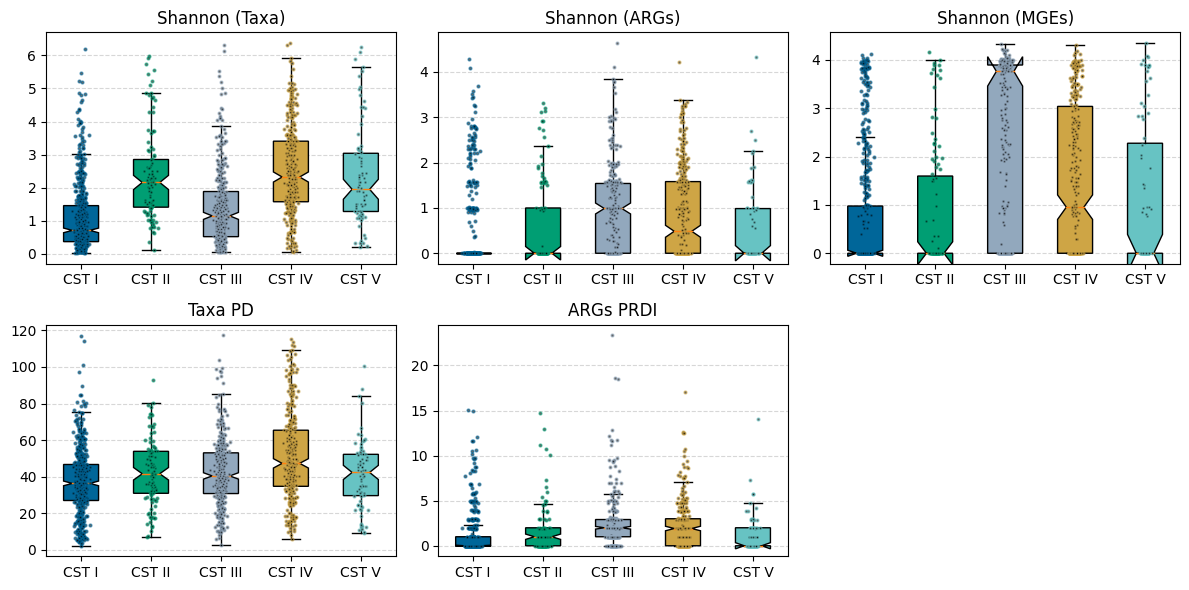

In [12]:
#plot by CST 
cst_colors = {'CST I':'#006699', 'CST II':'#009E73', 'CST III':'#92A8BD', 'CST IV':'#CEA545', 'CST V': '#67C3C3'}
order = ['CST I', 'CST II', 'CST III', 'CST IV', 'CST V']
fig, axes = plt.subplots(2,3, figsize = (12,6))

metadata_unique = metadata.drop_duplicates(subset="PATIENT")

plot_box(metrics_Shannon_df["Taxa_shannon"].loc[metadata_unique.index], metadata_unique, by="CST", order=order, colors=cst_colors, title="Shannon (Taxa)", plot=axes[0,0])
plot_box(metrics_Shannon_df["ARGs_shannon"].loc[metadata_unique.index], metadata_unique, by="CST", order=order, colors=cst_colors, title="Shannon (ARGs)", plot=axes[0,1])
plot_box(metrics_Shannon_df["MGEs_shannon"].loc[metadata_unique.index], metadata_unique, by="CST", order=order, colors=cst_colors, title="Shannon (MGEs)", plot=axes[0,2])
plot_box(metrics_PP_df["Taxa_PD"].loc[metadata_unique.index], metadata_unique, by="CST", order=order, colors=cst_colors, title="Taxa PD", plot=axes[1,0])
plot_box(metrics_PP_df["ARGs_PRDI"].loc[metadata_unique.index], metadata_unique, by="CST", order=order, colors=cst_colors, title="ARGs PRDI", plot=axes[1,1])

axes[1,2].axis("off")
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Shannon (MGEs)'}>

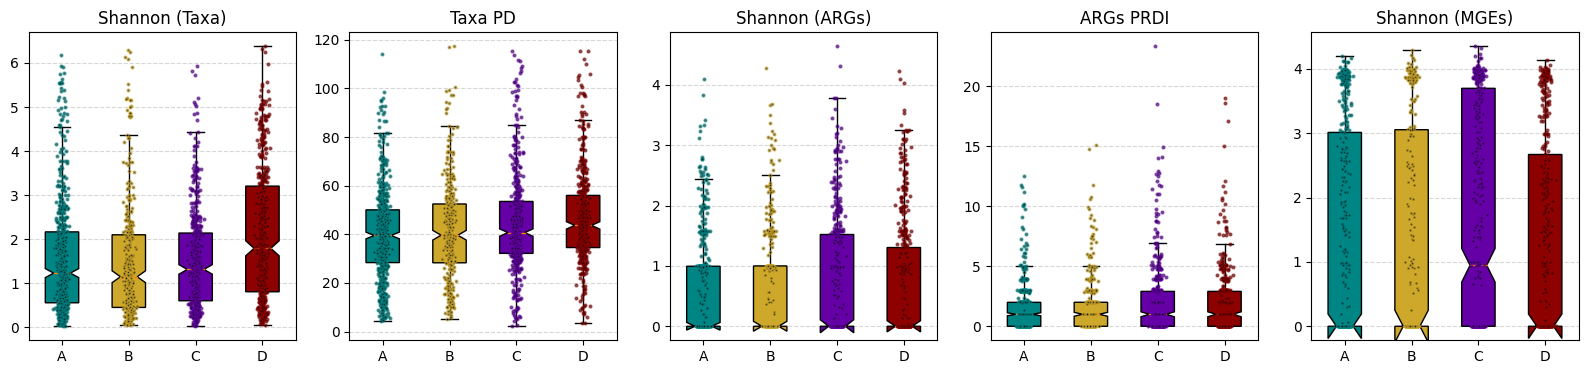

In [13]:
# Plot by clinical outcomes 
order = ["A", "B", "C", "D"]
out_colors = {"A": "#008585", "B": "#CEA82A", "C": "#6400A6", "D": "#8D0101"}
fig, axes = plt.subplots(1,5, figsize = (20,4))
plot_box(metrics_Shannon_df["Taxa_shannon"], metadata, by="OUT_GROUP", order = order, colors=out_colors, title="Shannon (Taxa)", plot=axes[0])
plot_box(metrics_PP_df["Taxa_PD"], metadata, by="OUT_GROUP", order = order, colors=out_colors, title="Taxa PD", plot=axes[1])
plot_box(metrics_Shannon_df["ARGs_shannon"], metadata, by="OUT_GROUP", order = order, colors=out_colors, title="Shannon (ARGs)", plot=axes[2])
plot_box(metrics_PP_df["ARGs_PRDI"], metadata, by="OUT_GROUP", order = order, colors=out_colors, title="ARGs PRDI", plot=axes[3])
plot_box(metrics_Shannon_df["MGEs_shannon"], metadata, by="OUT_GROUP", order = order, colors=out_colors, title="Shannon (MGEs)", plot=axes[4])

### (2.2) b-diversity 

In [14]:
def compute_dm(df, cols, metric=None):
    from skbio import DistanceMatrix
    from sklearn.metrics import pairwise_distances
    df_temp = df[cols].fillna(0)
    df_arr = df_temp.to_numpy()
    df_dist = pairwise_distances(df_arr, metric=metric)
    dm = DistanceMatrix(df_dist, ids=df_temp.index.tolist())
    return dm

def extract_dist(dm, metadata, by):
    dist_save = []
    ids = dm.ids 
    group = metadata.loc[list(ids),by]
    for i in range(len(ids)):
        id_i = ids[i]
        by_i = group.loc[id_i]
        for j in range(i + 1, len(ids)):
            id_j = ids[j]
            by_j = group.loc[id_j]
            dist = dm[i, j]
            if by_i == by_j: 
                dist_save.append({by : by_i, 'Distance': dist, 'Type': 'intra_group'})
            else:
                dist_save.append({by : by_i,'Distance': dist,'Type': 'inter_group'})
                dist_save.append({by : by_j,'Distance': dist,'Type': 'inter_group'})
    dm_df = pd.DataFrame(dist_save)
    return dm_df

def plot_density(dm_df, how=None, by=None, colors=None, color='black', bw_adjust=2, title=None, plot=None): 
    df_how = dm_df[dm_df["Type"] == how].copy()

    plot = plot or plt.gca()
    plot = sns.kdeplot(data=df_how, x="Distance", hue=by, palette=colors, fill=True, common_norm=False, alpha=0.3, linewidth=0.2, bw_adjust=bw_adjust, ax=plot)
    plot.set_xlim(-0.01, 1.01)  
    plot.set_title(f'{title}')
    plot.set_ylabel("Density")
    return plot 

In [15]:
#compute and extract intra-sample distances by CST 
Taxa_distance_matrix = compute_dm(Taxa_rabun, list(Taxa_rabun.columns), metric="braycurtis")
ARGs_distance_matrix = compute_dm(RF_ARGs_rabun, list(RF_ARGs_rabun.columns), metric="jaccard")
MGE_distance_matrix = compute_dm(MGE_rabun, list(MGE_rabun.columns), metric="jaccard")

Taxa_distance_df = extract_dist(Taxa_distance_matrix, metadata, "CST")
ARGs_distance_df = extract_dist(ARGs_distance_matrix, metadata, "CST")
MGE_distance_df = extract_dist(MGE_distance_matrix, metadata, "CST" )

c:\Users\Nassi\anaconda3\envs\mon_environnement\lib\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
c:\Users\Nassi\anaconda3\envs\mon_environnement\lib\site-packages\sklearn\metrics\pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


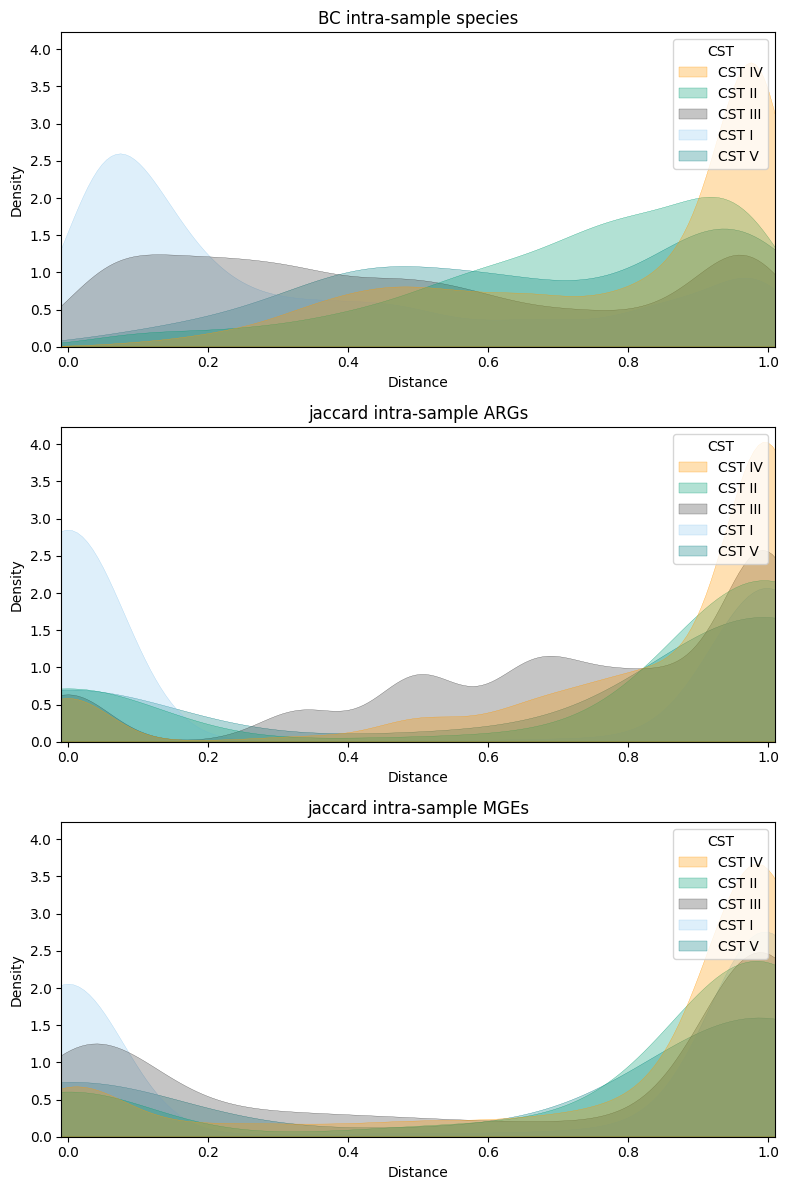

In [16]:
#Density plot 
cst_colors2 = {'CST I': '#92CAEF','CST II': '#009E73','CST III': '#404040','CST IV': '#FF9900','CST V': '#007C80'}
fig, axes = plt.subplots(3,1, figsize = (8,12), sharey=True)
plot_density(Taxa_distance_df, how="intra_group", by="CST", colors=cst_colors2, title= "BC intra-sample species", plot=axes[0])
plot_density(ARGs_distance_df, how="intra_group", by="CST", colors=cst_colors2, title= "jaccard intra-sample ARGs", plot=axes[1])
plot_density(MGE_distance_df, how="intra_group", by="CST", colors=cst_colors2, title = "jaccard intra-sample MGEs", plot=axes[2])
plt.tight_layout()
plt.show()

## (3) Differential Abundance plot

### load output data 

In [17]:
# load MaAslin2 ouput for clinical outcomes groups
ARG_df = pd.read_csv("../data/Output/ARG_DA_CPLM_OUT.csv")
ARGClass_df = pd.read_csv("../data/Output/ARGClass_DA_CPLM_OUT.csv")
taxa_df = pd.read_csv("../data/Output/Taxa_DA_LMCLR_OUT.csv")
MGE_df = pd.read_csv("../data/Output/MGE_DA_CPLM_OUT.csv")
MGEfamily_df = pd.read_csv("../data/Output/MGEfamily_DA_CPLM_OUT.csv")

# load MaAslin2 ouput for CST 
ARG_CST_df = pd.read_csv("../data/Output/ARG_DA_CPLM_CST.csv")
ARGClass_CST_df = pd.read_csv("../data/Output/ARGClass_DA_CPLM_CST.csv")
taxa_CST_df = pd.read_csv("../data/Output/Taxa_DA_LMCLR_CST.csv")
MGE_CST_df = pd.read_csv("../data/Output/MGE_DA_CPLM_CST.csv")
MGEfamily_CST_df = pd.read_csv("../data/Output/MGEfamily_DA_CPLM_CST.csv")

In [18]:
def get_top_sig(df, variable_name, top_n=10):
    df_var = df[df["variable"] == variable_name].copy()
    df_sig = df_var[df_var["q.value"] < 0.1].copy()
    df_sig["abs_estimate"] = df_sig["estimate"].abs()
    df_sig = df_sig.sort_values(by="abs_estimate", ascending=False)
    
    return df_sig.head(top_n)

def plot_maaslin_heatmap(maaslin_out,features_toplot,star1=0.1,star2=0.05,title=None,variables_interet=None,plot=None,):
    if variables_interet is not None:
        maaslin_out = maaslin_out[maaslin_out["variable"].isin(variables_interet)].copy()
    maaslin_out = maaslin_out[maaslin_out["feature"].isin(features_toplot)].copy()
    maaslin_out["var_level"] = maaslin_out["variable"].astype(str) + "_" + maaslin_out["level"].astype(str)
    heat_df = (maaslin_out.pivot_table(index="feature", columns="var_level", values="estimate", aggfunc="mean")
        .reindex(features_toplot))
    qmat_df = (maaslin_out.pivot_table(index="feature", columns="var_level", values="q.value", aggfunc="min")
        .reindex(features_toplot))

    if variables_interet is not None:
        ordered_cols = []
        for var in variables_interet:
            ordered_cols.extend([c for c in heat_df.columns if c.startswith(f"{var}_")])
        ordered_cols = [c for c in ordered_cols if c in heat_df.columns]
        heat_df = heat_df[ordered_cols]
        qmat_df = qmat_df[ordered_cols]

    # Annotation
    annotation = qmat_df.copy()
    for i in annotation.index:
        for j in annotation.columns:
            q = qmat_df.loc[i, j]
            if q < star2:
                annotation.loc[i, j] = "**"
            elif q < star1:
                annotation.loc[i, j] = "*"
            else:
                annotation.loc[i, j] = ""\
    #Plot
    plot = plot or plt.gca()
    sns.heatmap(heat_df,ax=plot,cmap="BrBG_r",center=0,linewidths=0.5,annot=annotation,fmt="", cbar_kws={"label": "MaAsLin2 effect size"})
    plot.set_xlabel("Variables and levels")
    plot.set_title(title)

    return plot

### Plot for CST 

                   feature variable level  estimate  std.error  p.value  \
0  Lactobacillus_crispatus      CST    IV -9.019862   0.181208      0.0   
1  Lactobacillus_crispatus      CST   III -8.821600   0.177327      0.0   

   q.value  method  abs_estimate  
0      0.0  LM_CLR      9.019862  
1      0.0  LM_CLR      8.821600  
    feature variable level  estimate  std.error       p.value       q.value  \
22  tet.32.      CST    IV  4.436191   0.698979  2.200184e-10  8.800737e-10   
28  tet.32.      CST   III  3.852867   0.756392  3.510628e-07  1.113716e-06   

   method  abs_estimate  
22   CPLM      4.436191  
28   CPLM      3.852867  
    feature variable level  estimate  std.error   p.value   q.value method  \
36  tnpAIS1      CST    II  1.905570   0.471092  0.000052  0.000390   CPLM   
31     int3      CST    II  1.708959   0.407962  0.000028  0.000242   CPLM   

    abs_estimate  
36      1.905570  
31      1.708959  


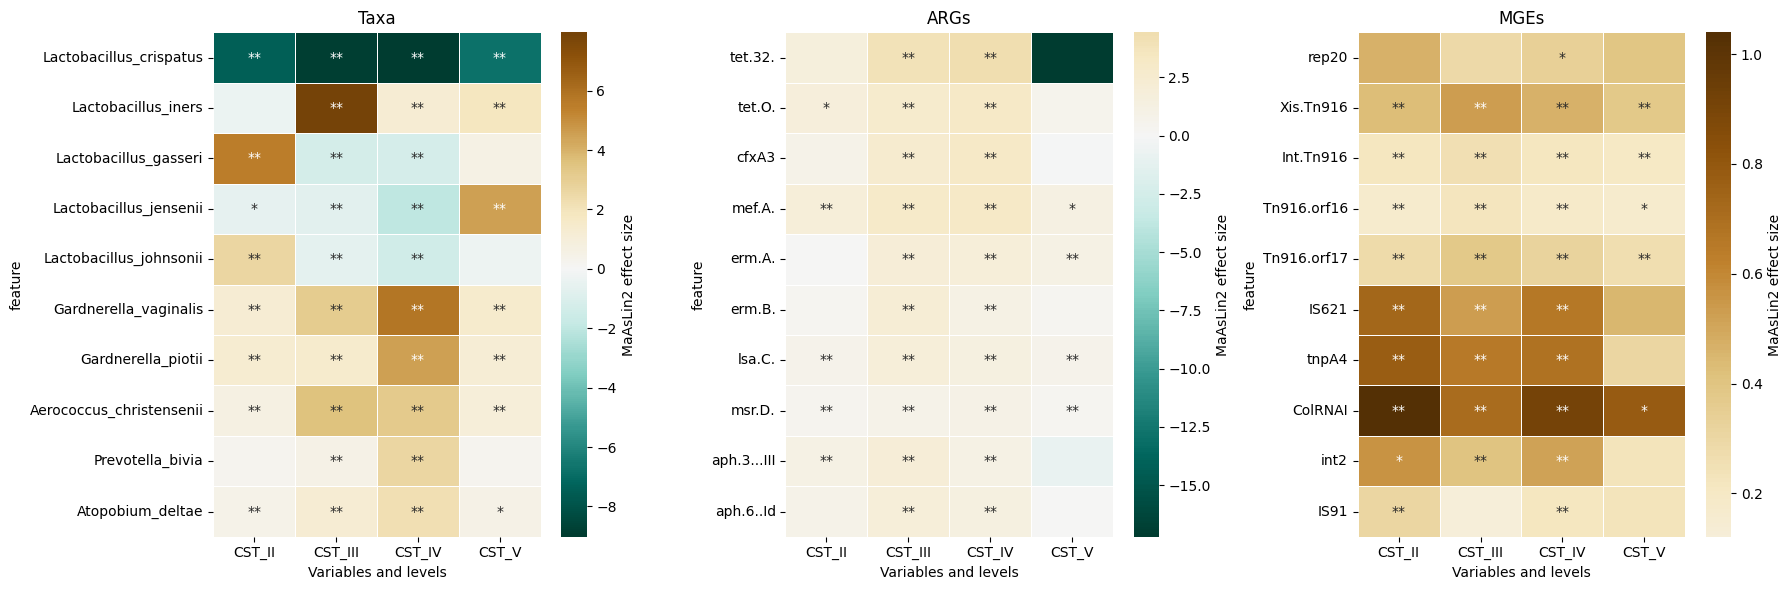

In [19]:
# for each maaslin_output extract and print top taxa (min q_value and max /estimate/
# Example for each output
print(get_top_sig(taxa_CST_df, "CST", top_n=2))
print(get_top_sig(ARG_CST_df, "CST", top_n=2))
print(get_top_sig(MGE_CST_df, "CST", top_n=2))
species_cst = ["Lactobacillus_crispatus","Lactobacillus_iners","Lactobacillus_gasseri","Lactobacillus_jensenii",
               "Lactobacillus_johnsonii","Gardnerella_vaginalis","Gardnerella_piotii",
               "Aerococcus_christensenii","Prevotella_bivia","Atopobium_deltae"]
arg_cst = ["tet.32.", "tet.O.", "cfxA3","mef.A.", "erm.A.", "erm.B.", "lsa.C.", "msr.D.", "aph.3...III", "aph.6..Id"] 		
mge_cst = ["rep20","Xis.Tn916","Int.Tn916", "Tn916.orf16","Tn916.orf17", "IS621","tnpA4", "ColRNAI", "int2", "IS91"]	
variable =["CST"]

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)
plot_maaslin_heatmap(maaslin_out=taxa_CST_df, features_toplot=species_cst,variables_interet=variable,
    star1=0.1, star2=0.05, title="Taxa",plot=axes[0])
plot_maaslin_heatmap(maaslin_out=ARG_CST_df, features_toplot=arg_cst, variables_interet=variable,
    star1=0.1, star2=0.05, title="ARGs", plot=axes[1])
plot_maaslin_heatmap(maaslin_out=MGE_CST_df,features_toplot=mge_cst,variables_interet=variable,
    star1=0.1, star2=0.05,title="MGEs",plot=axes[2])
plt.tight_layout()
plt.show()


### Plot for Clinical variables 

In [20]:
# for each maaslin_output extract and print top taxa (min q_value and max /estimate/
# Example for each output
print(get_top_sig(taxa_df, "OUT_GROUP", top_n=2))
print(get_top_sig(ARG_df, "OUT_GROUP", top_n=2))
print(get_top_sig(MGEfamily_df, "OUT_GROUP", top_n=2))

                     feature   variable level  estimate  std.error  \
9      Lactobacillus_gasseri  OUT_GROUP     D -1.638670   0.253253   
3  Lactobacillus_paragasseri  OUT_GROUP     D -1.598868   0.230051   

        p.value       q.value  method  abs_estimate  
9  1.313588e-10  1.182230e-08  LM_CLR      1.638670  
3  5.407599e-12  1.216710e-09  LM_CLR      1.598868  
   feature   variable level  estimate  std.error   p.value   q.value method  \
67  erm.B.  OUT_GROUP     C  0.127045   0.039208  0.001194  0.021391   CPLM   
73  lsa.C.  OUT_GROUP     C  0.118808   0.037595  0.001577  0.025952   CPLM   

    abs_estimate  
67      0.127045  
73      0.118808  
             feature   variable level  estimate  std.error   p.value  \
7   IncFIB.AP001918.  OUT_GROUP     C  2.428097   0.891231  0.006441   
15  IncFIB.AP001918.  OUT_GROUP     B  2.169013   0.903038  0.016310   

     q.value method  abs_estimate  
7   0.070007   CPLM      2.428097  
15  0.086347   CPLM      2.169013  


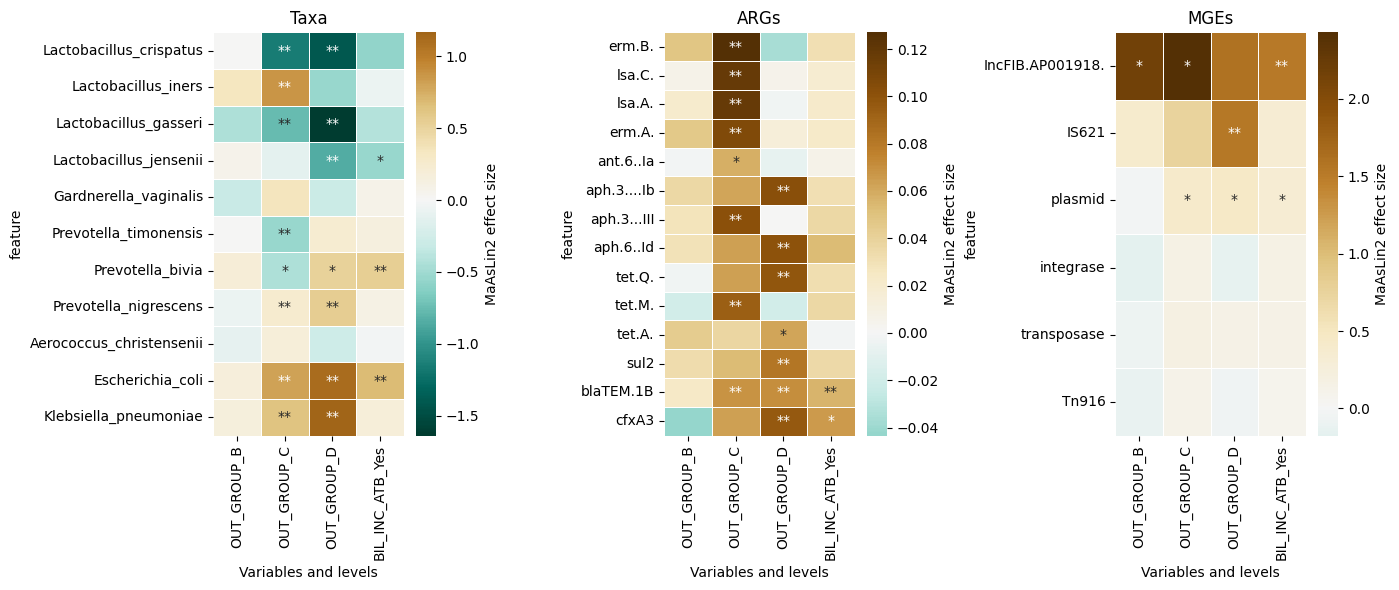

In [21]:
# Plot species, ARGs and MGE 
taxa_out = ['Lactobacillus_crispatus','Lactobacillus_iners','Lactobacillus_gasseri','Lactobacillus_jensenii',
                           'Gardnerella_vaginalis','Prevotella_timonensis','Prevotella_bivia','Prevotella_nigrescens',
                           'Aerococcus_christensenii','Escherichia_coli','Klebsiella_pneumoniae']
arg_out = ['erm.B.','lsa.C.','lsa.A.','erm.A.','ant.6..Ia','aph.3....Ib','aph.3...III',
             'aph.6..Id','tet.Q.','tet.M.','tet.A.','sul2','blaTEM.1B','cfxA3']
mge_family_out = ['IncFIB.AP001918.','IS621','plasmid', 'integrase', 'transposase', 'Tn916']
variables = ["OUT_GROUP","BIL_INC_ATB"]

fig, axes = plt.subplots(1, 3, figsize=(14, 6), sharey=False)
plot_maaslin_heatmap(maaslin_out=taxa_df, features_toplot=taxa_out,variables_interet=variables,
    star1=0.1, star2=0.05, title="Taxa",plot=axes[0])
plot_maaslin_heatmap(maaslin_out=ARG_df, features_toplot=arg_out, variables_interet=variables,
    star1=0.1, star2=0.05, title="ARGs", plot=axes[1])
plot_maaslin_heatmap(maaslin_out=MGEfamily_df,features_toplot=mge_family_out,variables_interet=variables,
    star1=0.1, star2=0.05,title="MGEs",plot=axes[2],)
plt.tight_layout()

<Axes: title={'center': 'ARGs'}, xlabel='Variables and levels', ylabel='feature'>

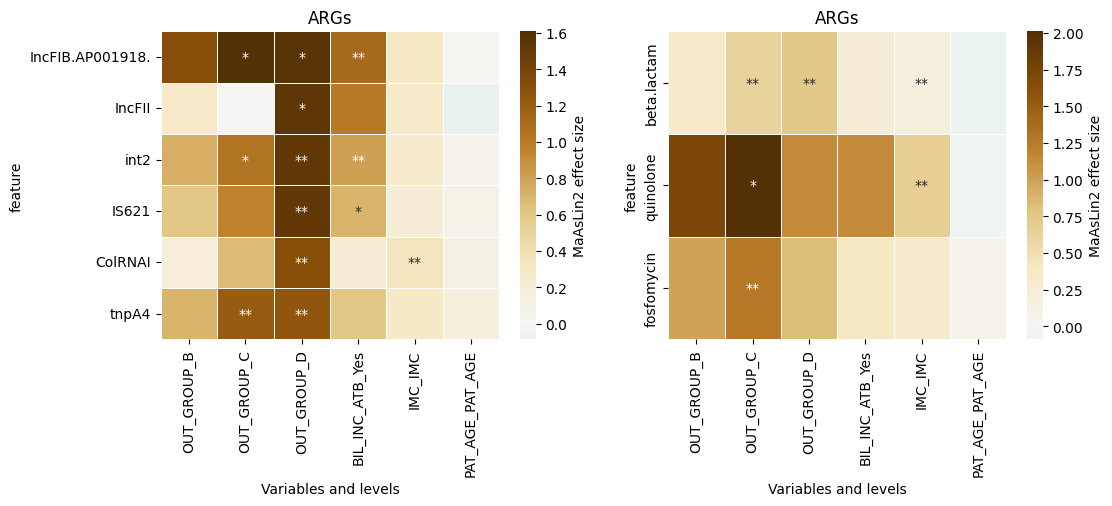

In [22]:
# Plot ARGs classes and MGEs features (supplementary) 
order_mge = ["IncFIB.AP001918.","IncFII","int2", "IS621", "ColRNAI","tnpA4"]
order_ARGClass = ["beta.lactam", "quinolone", "fosfomycin"]
variables = ["OUT_GROUP","BIL_INC_ATB","IMC",'PAT_AGE']

fig, axes = plt.subplots(1,2, figsize=(12,4), sharey= False)
plot_maaslin_heatmap(maaslin_out=MGE_df, features_toplot=order_mge, variables_interet=variables,
    star1=0.1, star2=0.05, title="ARGs", plot=axes[0])
plot_maaslin_heatmap(maaslin_out=ARGClass_df, features_toplot=order_ARGClass, variables_interet=variables,
    star1=0.1, star2=0.05, title="ARGs", plot=axes[1])

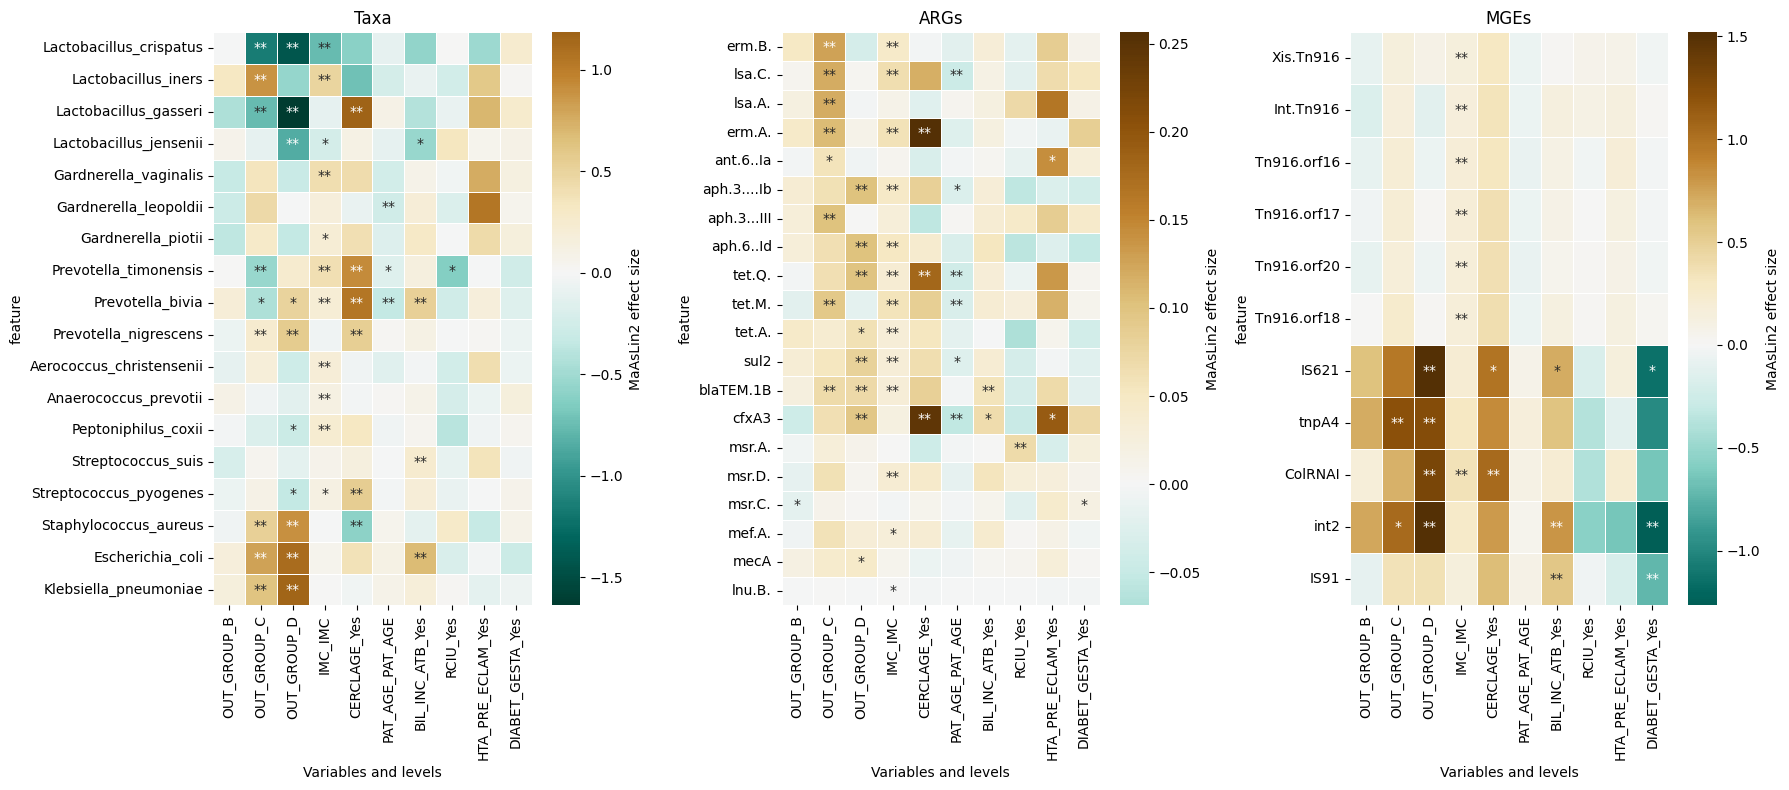

In [23]:
# Plot species, ARGs and MGE (Extended to all variables and more features) 
species_out_extend = ['Lactobacillus_crispatus','Lactobacillus_iners','Lactobacillus_gasseri','Lactobacillus_jensenii',
                           'Gardnerella_vaginalis','Gardnerella_leopoldii','Gardnerella_piotii','Prevotella_timonensis',
                           'Prevotella_bivia','Prevotella_nigrescens','Aerococcus_christensenii','Anaerococcus_prevotii',
                           'Peptoniphilus_coxii','Streptococcus_suis','Streptococcus_pyogenes','Staphylococcus_aureus',
                           'Escherichia_coli','Klebsiella_pneumoniae',]
arg_out_extend = ['erm.B.','lsa.C.','lsa.A.', 'erm.A.','ant.6..Ia','aph.3....Ib','aph.3...III',
             'aph.6..Id','tet.Q.','tet.M.','tet.A.','sul2','blaTEM.1B','cfxA3','msr.A.',
             'msr.D.','msr.C.','mef.A.','mecA','lnu.B.']
mge_out_extend = ["Xis.Tn916","Int.Tn916", "Tn916.orf16","Tn916.orf17","Tn916.orf20","Tn916.orf18", "IS621","tnpA4", "ColRNAI", "int2", "IS91"]	
variables_all = ['OUT_GROUP', 'IMC', 'CERCLAGE', 'PAT_AGE', 'BIL_INC_ATB', 'RCIU',
       'HTA_PRE_ECLAM', 'DIABET_GESTA']

fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=False)
plot_maaslin_heatmap(maaslin_out=taxa_df, features_toplot=species_out_extend,variables_interet=variables_all,
    star1=0.1, star2=0.05, title="Taxa",plot=axes[0])
plot_maaslin_heatmap(maaslin_out=ARG_df, features_toplot=arg_out_extend, variables_interet=variables_all,
    star1=0.1, star2=0.05, title="ARGs", plot=axes[1])
plot_maaslin_heatmap(maaslin_out=MGE_df,features_toplot=mge_out_extend,variables_interet=variables_all,
    star1=0.1, star2=0.05,title="MGEs",plot=axes[2],)
plt.tight_layout()

## (4) Cross validation 

### Cross validation of ARG detection using another ARG database (CARD)

Here, we aimed to cross-check our ARGs detection using an extended antimicrobial resistance genes determinants database (CARD) (https://card.mcmaster.ca/).  

**Note**: CARD includes not only acquired antimicrobial resistance genes, but also resistance to disinfectants as well as resistance conferred by point mutations (SNPs).

In [24]:
# Load data & dictionary
CARD_ARGs_abun = pd.read_csv("../data/Norm/ARGs_count_CARD_RGI_RPKM_Gene.csv", index_col='SampleID')

with open("../data/supp_materials/CARD_gene_info_dict.json") as f:
    CARD_dict = json.load(f)

In [25]:

CARD_Shannon_ARGs = compute_alpha(CARD_ARGs_abun, metric="shannon")
#dfs to plot 
CARD_metrics_Shannon_df = pd.DataFrame({"Shannon": CARD_Shannon_ARGs})
CARD_metrics_Shannon_df.index= CARD_metrics_Shannon_df.index.rename("SampleID")

Mean total ARGs seq using CARD Db : 467617.102871669
Mean total ARGs seq using acquired RF DB : 434820.9189151128
(1957, 492)
(1957, 19)


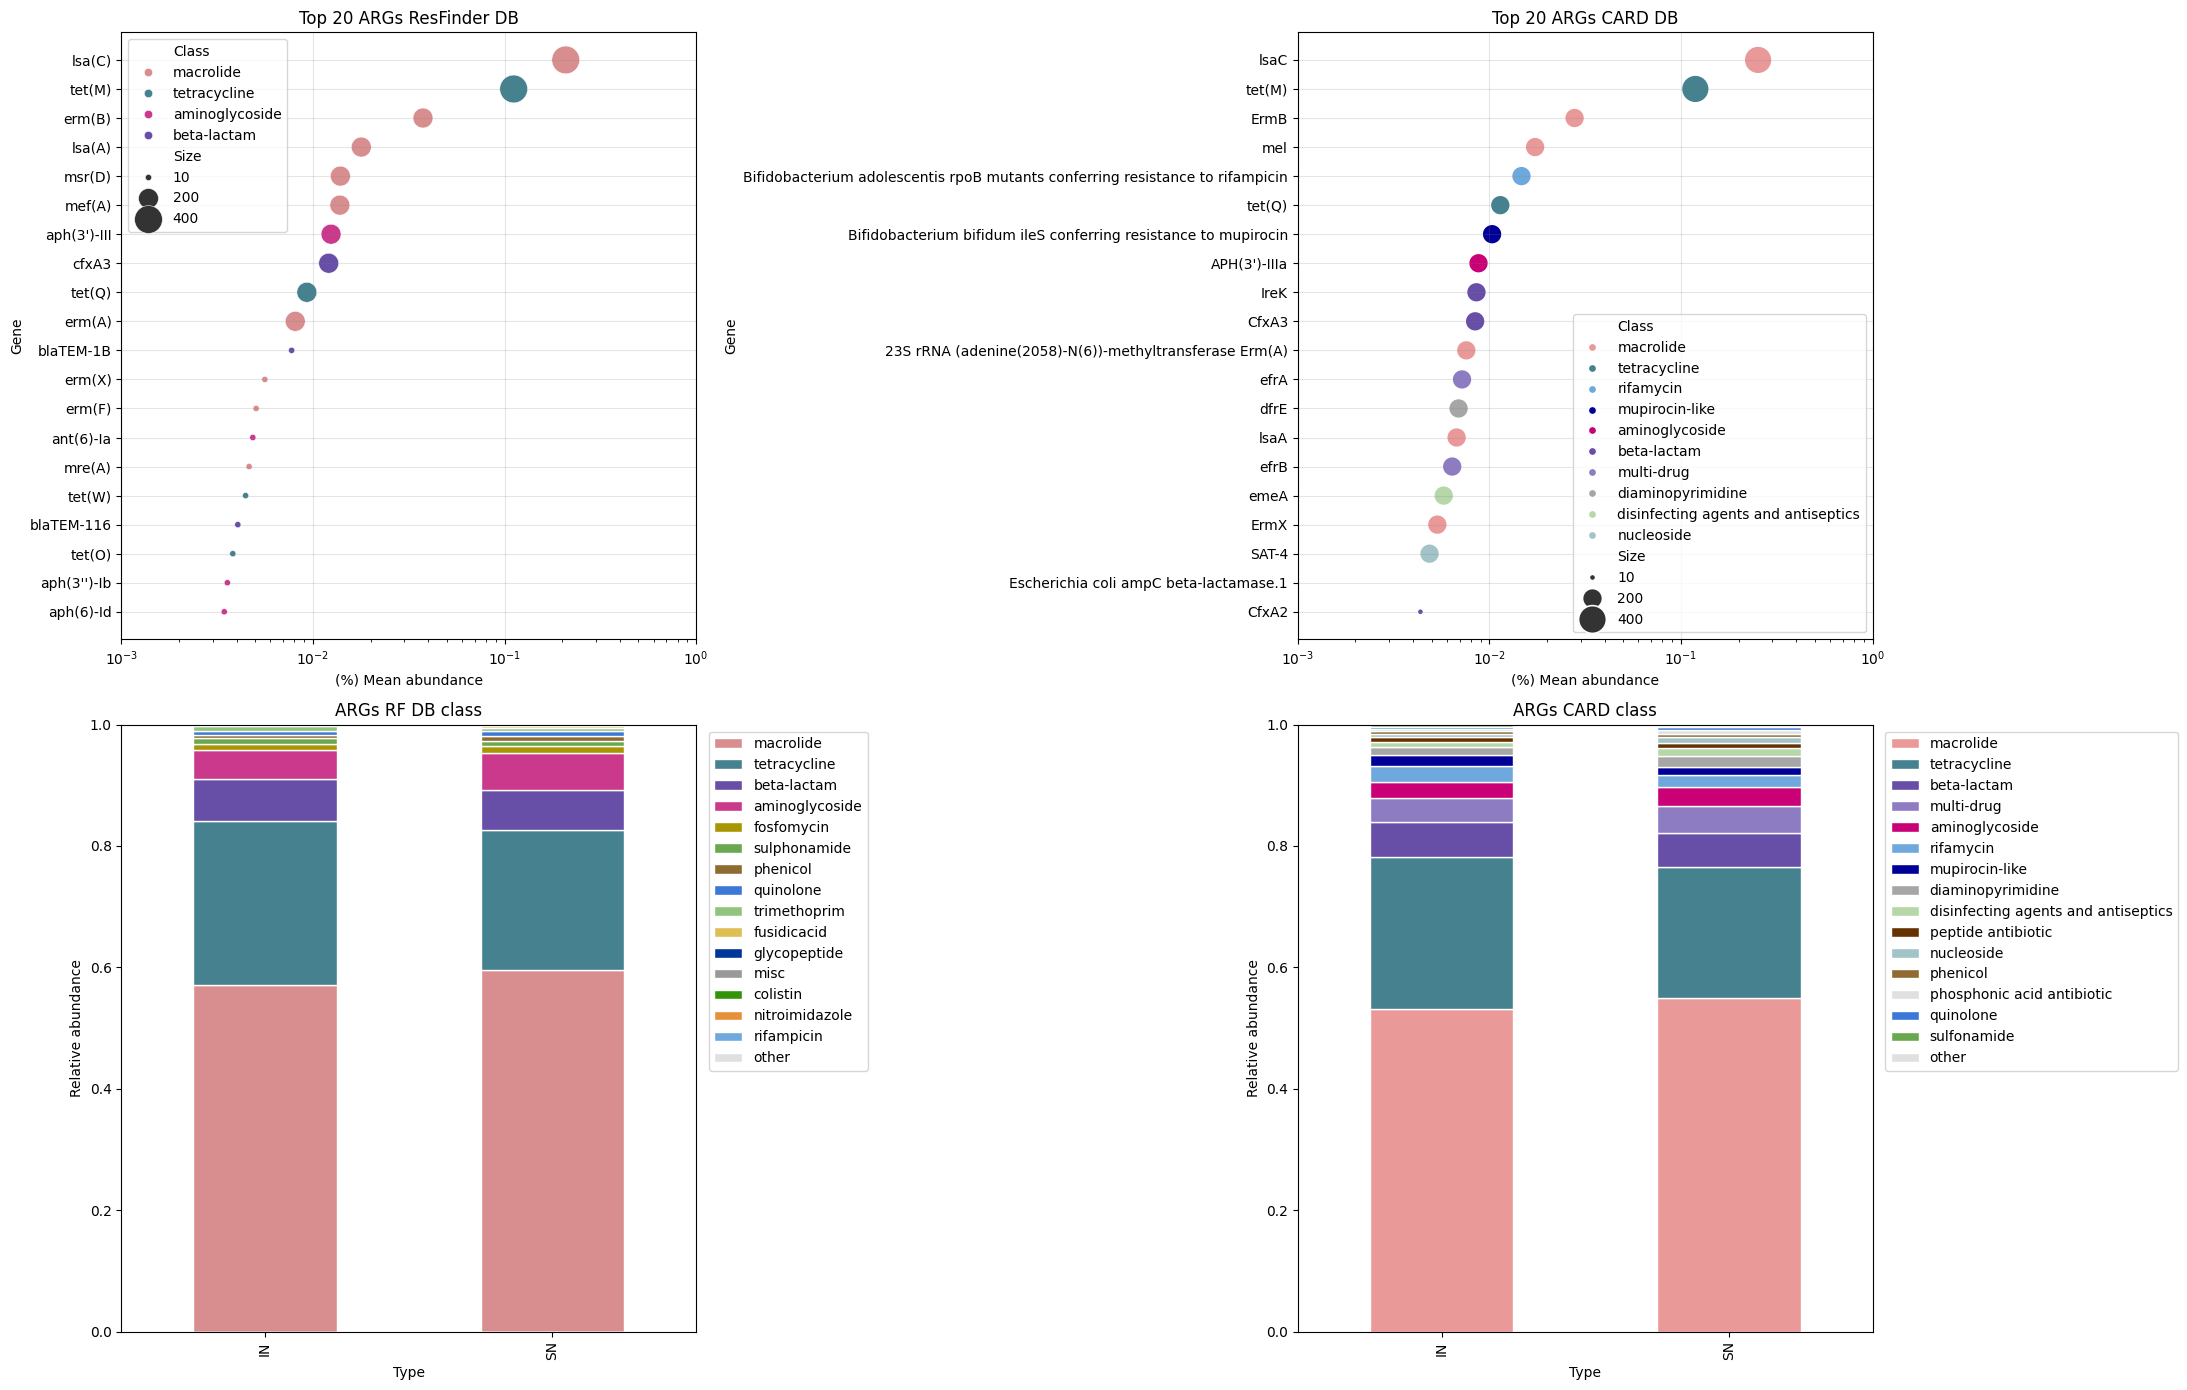

In [26]:
mean_seq_CARD = CARD_ARGs_abun.sum(axis=1).mean()
mean_seq_RF = RF_ARGs_abun.sum(axis=1).mean()
print(f'Mean total ARGs seq using CARD Db : {mean_seq_CARD}')
print(f'Mean total ARGs seq using acquired RF DB : {mean_seq_RF}')

# format CARD frequency table to relative abundance at antibiotic class level
gene_to_class_CARD = {entry['Gene Name']: entry ['Drug Class Simplified'] for entry in CARD_dict} # (simplified class : ARG Classes manually curated to best fit RF classes)
CARD_ARGs_rabun = calc_rabun(CARD_ARGs_abun)
print(CARD_ARGs_rabun.shape)
CARD_ARGs_rabun_class = CARD_ARGs_rabun.copy()
CARD_ARGs_rabun_class.columns = CARD_ARGs_rabun_class.columns.map(gene_to_class_CARD)
CARD_ARGs_rabun_class=CARD_ARGs_rabun_class.groupby(level =0, axis=1).sum()
print(CARD_ARGs_rabun_class.shape)

#plot distribution RF vs CARD 
class_palette_CARD = {"aminoglycoside": "#c90076","beta-lactam": "#674ea7","macrolide": "#ea9999","tetracycline": "#45818e","diaminopyrimidine": "#a6a6a6",
                      "multi-drug": "#8e7cc3","rifamycin": "#6fa8dc","nucleoside": "#a2c4c9","disinfecting agents and antiseptics": "#b6d7a8",
                      "peptide antibiotic": "#663300","mupirocin-like": "#000099","unknown": "#E0E0E0","phenicol": "#8F6B32", "phosphonic acid antibiotic":"#E0E0E0",
                      "quinolone": "#3C78D8","sulfonamide": "#6AA84F","other":"#E0E0E0"}

fig,axes = plt.subplots(2,2, figsize = (22,14))
plot_bubble(RF_ARGs_rabun, RF_dict, top=20, gene_entry="Gene",class_entry="Antibiotic_Class", class_colors=class_palette_RF,title="Top 20 ARGs ResFinder DB", plot=axes[0,0])
plot_bubble(CARD_ARGs_rabun, CARD_dict, top=20, gene_entry='Gene Name',class_entry='Drug Class Simplified', class_colors=class_palette_CARD,title="Top 20 ARGs CARD DB", plot=axes[0,1])
plot_barchart(RF_ARGs_rabun_class, metadata, by="Type", top=15, color_map=class_palette_RF, title="ARGs RF DB class",    plot=axes[1,0])
plot_barchart(CARD_ARGs_rabun_class, metadata, by="Type", top=15, color_map=class_palette_CARD, title="ARGs CARD class",    plot=axes[1,1])
plt.tight_layout()
plt.show()

### Cross validation of ARG detection using an external independent cohort study
Here, we cross-validated our observations using a previously published independent cohort of pregnant women from Ireland.
A total of 89 Vaginal samples were sequenced using shotgun metagenomics approach.

**Study information** :

Feehily, C., Crosby, D., Walsh, C.J. et al.
Shotgun sequencing of the vaginal microbiome reveals both a species and functional potential signature of preterm birth.
#npj Biofilms Microbiomes 6, 50 (2020). https://doi.org/10.1038/s41522-020-00162-8

Raw Sequence data have been deposited in the European Nucleotide Archive (ENA) under the study accession number PRJEB34536.

In [27]:
# load data 
ED_RF_ARGs_abun = pd.read_csv("../data/Norm/ExtSet_ARGs_count_RF_RPKM_Gene.csv", index_col= "SampleID")
ED_CST = pd.read_csv("../data/ExternalDataset_CST.csv",  index_col= "SampleID")

In [28]:
ED_RF_ARGs_rabun =  calc_rabun(ED_RF_ARGs_abun)
print(ED_RF_ARGs_rabun.shape)

gene_to_class = {entry["Gene"]: entry["Antibiotic_Class"] for entry in RF_dict}

ED_RF_ARGs_rabun_class = ED_RF_ARGs_rabun.copy()
ED_RF_ARGs_rabun_class.columns = ED_RF_ARGs_rabun_class.columns.map(gene_to_class)
ED_RF_ARGs_rabun_class = ED_RF_ARGs_rabun_class.groupby(level=0,axis=1).sum()
print(ED_RF_ARGs_rabun_class.shape)

# Convert gene to Accession numbers and format to fit the PhenoARG tree ARG Acc.No 
Gene_to_Acc = {entry["Gene"] : entry["Accession"] for entry in RF_dict}
ED_RF_ARGs_abun_Acc = ED_RF_ARGs_abun.copy()
ED_RF_ARGs_abun_Acc.columns = ED_RF_ARGs_abun_Acc.columns.map(Gene_to_Acc)
ED_RF_ARGs_abun_Acc = ED_RF_ARGs_abun_Acc.groupby(level=0, axis=1).sum()
ED_RF_ARGs_abun_Acc.columns = ED_RF_ARGs_abun_Acc.columns.str.replace(r"^NC_", "NC ", regex=True).str.replace(r"^NG_", "NG ", regex=True)

#Compute a-div 
inspire_shannon_ARGs = compute_alpha(RF_ARGs_rabun, metric="shannon")   
ED_Shannon_ARGs = compute_alpha(ED_RF_ARGs_rabun, metric="shannon")
PRDI_ARGs_ED =  compute_alpha(ED_RF_ARGs_abun_Acc, metric="faith_pd", tree = tree_rooted_ARG)

#dfs to plot 
inspire_metrics_Shannon_df = pd.DataFrame({"inspire_shannon": inspire_shannon_ARGs})
ED_metrics_df = pd.DataFrame({"ED_shannon": ED_Shannon_ARGs, "ED_PD": PRDI_ARGs_ED})

(89, 12)
(89, 3)


<Axes: title={'center': 'ARGs Shannon Div External Dataset'}>

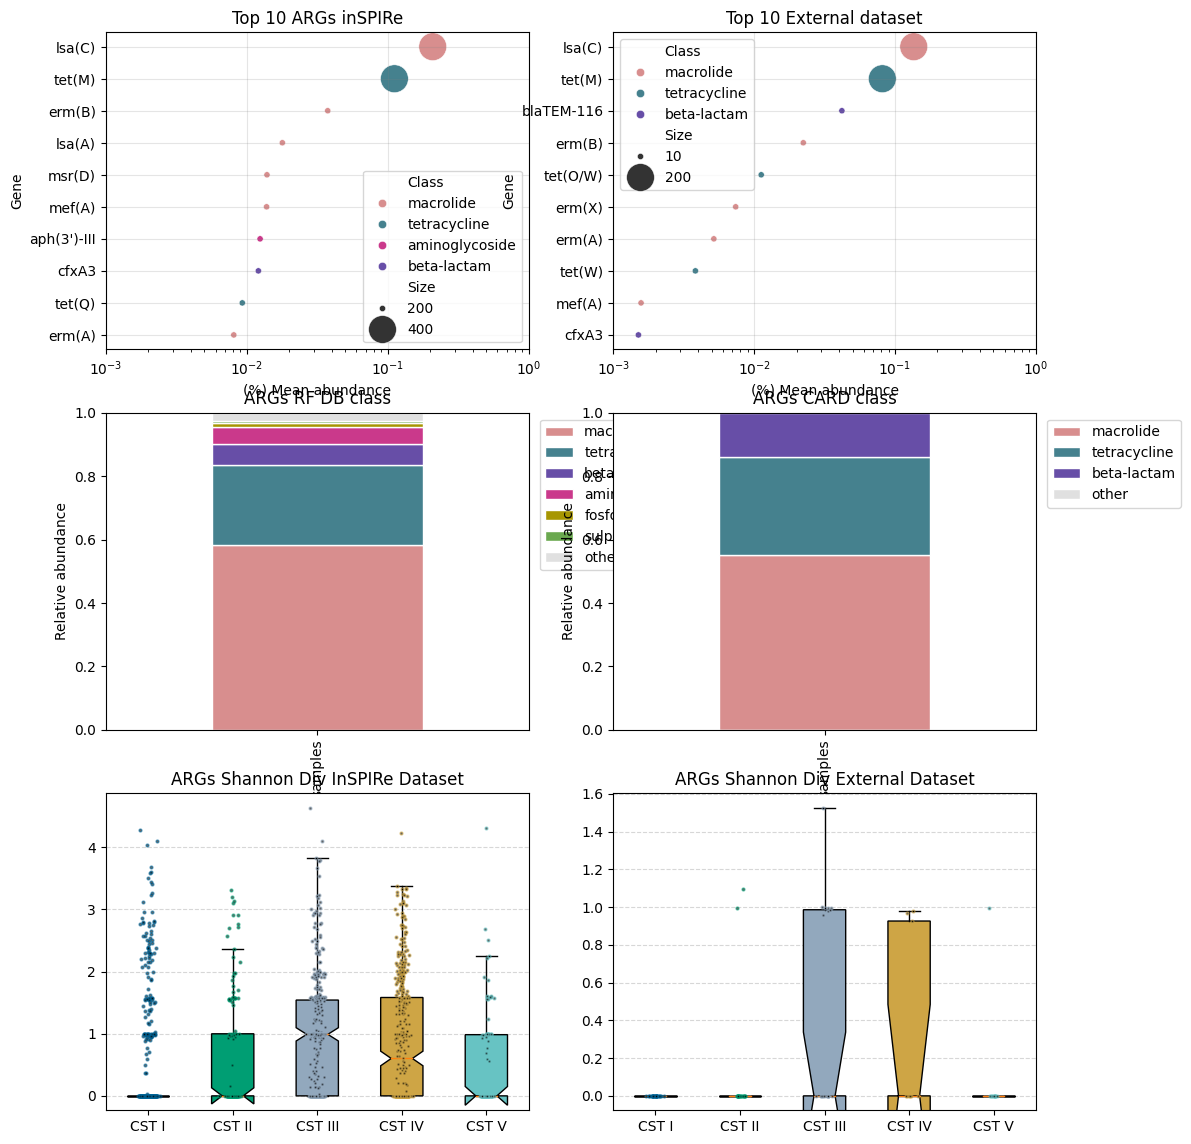

In [29]:
colors_ARGs = {'lsa(C)': '#CB981A', 'tet(M)': '#43838B', 'erm(B)': '#138A6F','erm(A)': '#138A6F','cfxA3': "#3C3F6E",
               'lsa(A)': '#6E9B2D', 'msr(D)': '#9D7D2C', 'mef(A)': '#B95C0B',"aph(3')-III":"#910707",'tet(W)':'#43838B',
               'other': '#E0E0E0', 'blaTEM-116':"#3D45AF", 'tet(O/W)': "#63BAC5", 'erm(X)':'#3AC4A3'}
order = ['CST I', 'CST II', 'CST III', 'CST IV', 'CST V']

fig,axes = plt.subplots(3,2, figsize = (12,14))

plot_bubble(RF_ARGs_rabun, RF_dict, top=10, gene_entry="Gene",class_entry="Antibiotic_Class", class_colors=class_palette_RF,title="Top 10 ARGs inSPIRe", plot=axes[0,0])
plot_bubble(ED_RF_ARGs_rabun, RF_dict, top=10, gene_entry='Gene',class_entry='Antibiotic_Class', class_colors=class_palette_RF,title="Top 10 External dataset", plot=axes[0,1])

plot_barchart(RF_ARGs_rabun_class, top=6, color_map=class_palette_RF, title="ARGs RF DB class", plot=axes[1,0])
plot_barchart(ED_RF_ARGs_rabun_class, top=6, color_map=class_palette_RF, title="ARGs CARD class",plot=axes[1,1])

plot_box(inspire_metrics_Shannon_df["inspire_shannon"], metadata, by="CST", order = order, colors=cst_colors, title="ARGs Shannon Div InSPIRe Dataset", plot=axes[2,0])
plot_box(ED_metrics_df["ED_shannon"], ED_CST, by="CST", order = order, colors=cst_colors, title="ARGs Shannon Div External Dataset", plot=axes[2,1])